In [1]:
import numpy as np
import random

# Set a global random seed
SEED = 42
np.random.seed(SEED)
random.seed(SEED)


In [2]:
"""MultiRocketHydra classifier.

Pipeline classifier concatenating the MultiRocket and Hydra transformers with a
RidgeClassifierCV estimator.
"""

import numpy as np
from sklearn.linear_model import RidgeClassifierCV
from sklearn.preprocessing import StandardScaler

from aeon.classification import BaseClassifier
from aeon.classification.convolution_based._hydra import _SparseScaler
from aeon.transformations.collection.convolution_based import MultiRocket
from aeon.transformations.collection.convolution_based._hydra import HydraTransformer


class MultiRocketHydraClassifier(BaseClassifier):
    """MultiRocket-Hydra Classifier.

    A combination of the Hydra and MultiRocket algorithms. The algorithm concatenates
    the output of both algorithms and trains a linear classifier on the combined
    features.

    See both individual classifier/transformation for more details.

    Parameters
    ----------
    n_kernels : int, default=8
        Number of kernels per group for the Hydra transform.
    n_groups : int, default=64
        Number of groups per dilation for the Hydra transform.
    class_weight{None, “balanced”}, dict or list of dicts, default=None
        From sklearn documentation:
        If None, all classes are assigned equal weights.
        The “balanced” mode uses the values of y to automatically adjust weights
        inversely proportional to class frequencies in the input data as
        n_samples / (n_classes * np.bincount(y))
        For multi-output, the weights of each column of y will be multiplied.
        A dictionary can also be provided to specify weights for each class manually.
        Note that these weights will be multiplied with sample_weight (passed through
        the fit method) if sample_weight is specified.
        Note: "balanced_subsample" is not supported as RidgeClassifierCV
        is not an ensemble model.
    n_jobs : int, default=1
        The number of jobs to run in parallel for both `fit` and `predict`.
        ``-1`` means using all processors.
    random_state : int, RandomState instance or None, default=None
        If `int`, random_state is the seed used by the random number generator;
        If `RandomState` instance, random_state is the random number generator;
        If `None`, the random number generator is the `RandomState` instance used
        by `np.random`.

    Attributes
    ----------
    n_classes_ : int
        Number of classes. Extracted from the data.
    classes_ : ndarray of shape (n_classes_)
        Holds the label for each class.

    See Also
    --------
    HydraClassifier
    RocketClassifier

    References
    ----------
    .. [1] Dempster, A., Schmidt, D.F. and Webb, G.I., 2023. Hydra: Competing
        convolutional kernels for fast and accurate time series classification.
        Data Mining and Knowledge Discovery, pp.1-27.

    Examples
    --------
    >>> from aeon.classification.convolution_based import MultiRocketHydraClassifier
    >>> from aeon.testing.data_generation import make_example_3d_numpy
    >>> X, y = make_example_3d_numpy(n_cases=10, n_channels=1, n_timepoints=12,
    ...                              random_state=0)
    >>> clf = MultiRocketHydraClassifier(random_state=0)  # doctest: +SKIP
    >>> clf.fit(X, y)  # doctest: +SKIP
    MultiRocketHydraClassifier(random_state=0)
    >>> clf.predict(X)  # doctest: +SKIP
    array([0, 1, 0, 1, 0, 0, 1, 1, 1, 0])
    """

    _tags = {
        "capability:multivariate": True,
        "capability:multithreading": True,
        "algorithm_type": "convolution",
        "python_dependencies": "torch",
    }

    def __init__(
        self,
        n_kernels: int = 8,
        n_groups: int = 64,
        class_weight=None,
        n_jobs: int = 1,
        random_state=None,
    ):
        self.n_kernels = n_kernels
        self.n_groups = n_groups
        self.class_weight = class_weight
        self.n_jobs = n_jobs
        self.random_state = random_state

        super().__init__()

    def _fit(self, X, y):
        self._transform_hydra = HydraTransformer(
            n_kernels=self.n_kernels,
            n_groups=self.n_groups,
            n_jobs=self.n_jobs,
            random_state=self.random_state,
        )
        Xt_hydra = self._transform_hydra.fit_transform(X)

        self._scale_hydra = _SparseScaler()
        Xt_hydra = self._scale_hydra.fit_transform(Xt_hydra)

        self._transform_multirocket = MultiRocket(
            n_jobs=self.n_jobs,
            random_state=self.random_state,
        )
        Xt_multirocket = self._transform_multirocket.fit_transform(X)

        self._scale_multirocket = StandardScaler()
        Xt_multirocket = self._scale_multirocket.fit_transform(Xt_multirocket)

        Xt = np.concatenate((Xt_hydra, Xt_multirocket), axis=1)

        self.classifier = RidgeClassifierCV(
            alphas=np.logspace(-3, 3, 10), class_weight=self.class_weight
        )
        self.classifier.fit(Xt, y)

        return self

    def _predict(self, X) -> np.ndarray:
        Xt_hydra = self._transform_hydra.transform(X)
        Xt_hydra = self._scale_hydra.transform(Xt_hydra)

        Xt_multirocket = self._transform_multirocket.transform(X)
        Xt_multirocket = self._scale_multirocket.transform(Xt_multirocket)

        Xt = np.concatenate((Xt_hydra, Xt_multirocket), axis=1)

        return self.classifier.predict(Xt)

In [3]:
import os
import numpy as np
import librosa

def load_data_from_directory(directory, sample_length=16000, n_channels=1):
    X = []
    y = []
    labels = sorted(os.listdir(directory))
    label_map = {label: idx for idx, label in enumerate(labels)}  # Create a label to index mapping

    total_files = 0  # Initialize a counter for total files

    for label in labels:
        class_dir = os.path.join(directory, label)
        if os.path.isdir(class_dir):
            file_count = 0  # Counter for files in the current class directory
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.wav'):
                    file_count += 1  # Increment file count for the current class
                    file_path = os.path.join(class_dir, file_name)
                    # Load audio
                    signal, sr = librosa.load(file_path, sr=16000)
                    # Ensure length is 1 second (16000 samples)
                    if len(signal) != sample_length:
                        # Pad or truncate to sample_length
                        if len(signal) < sample_length:
                            signal = np.pad(signal, (0, sample_length - len(signal)))
                        else:
                            signal = signal[:sample_length]
                    # Reshape signal to match (n_channels, n_timepoints)
                    X.append(signal.reshape(n_channels, -1))  # Reshape to (1, sample_length)
                    y.append(label_map[label])  # Use the index of the label

            total_files += file_count  # Add the current class file count to the total
            print(f"Total number of files in folder '{label}': {file_count}")

    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)

    print(X.shape)
    print(y.shape)
    print(y)
    print(f"Overall total number of files in the dataset: {total_files}")

    return X, y, labels

# Load and preprocess data
directory = "C:/Users/WORKSTATIONS/Desktop/BijoyashreeDas/12KWS"
X, y, labels = load_data_from_directory(directory)


Total number of files in folder 'down': 2359
Total number of files in folder 'go': 2372
Total number of files in folder 'left': 2353
Total number of files in folder 'no': 2375
Total number of files in folder 'off': 2357
Total number of files in folder 'on': 2367
Total number of files in folder 'right': 2367
Total number of files in folder 'silence': 2010
Total number of files in folder 'stop': 2380
Total number of files in folder 'unknown': 2000
Total number of files in folder 'up': 2375
Total number of files in folder 'yes': 2377
(27692, 1, 16000)
(27692,)
[ 0  0  0 ... 11 11 11]
Overall total number of files in the dataset: 27692


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [5]:



# Split data into training and testing sets with a fixed random_state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)






In [6]:
# Initialize the Classifier

clf = MultiRocketHydraClassifier(
    random_state=SEED
)







In [7]:
# Fit the classifier on the training data
clf.fit(X_train, y_train)

Catch22Classifier(random_state=42)

In [8]:
# Predict on the test set
y_pred = clf.predict(X_test)

# Print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test data:", accuracy)

Accuracy on test data: 0.4814948546669074


In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and f1 score for each class (macro average)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision (macro): {precision}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")





Precision (macro): 0.48140048324983625
Recall (macro): 0.48725137963103055
F1 Score (macro): 0.47667949412491906


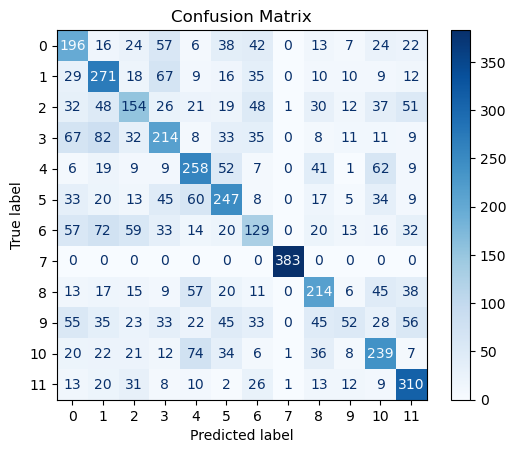

In [10]:
#confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay


# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


